In [380]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 로드

In [381]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/exp11')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel/exp11


# 파일 수 확인

In [382]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


# 트레인  데이터와 벨리데이션 데이터의 불균형이 심각하여 8:2로 다시 나눠줍니다.

In [383]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [384]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/exp11/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg
Pneumonia image path
/aiffel/aiffel/exp11/chest_xray/data/train/PNEUMONIA/person614_bacteria_2483.jpeg


# 양성과 음성 사진 수 확인

In [385]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [386]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


# 사진 라벨링

In [387]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
BATCH_SIZE = 32

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

***

# 예제 모델링

# Batch사이즈와 Epoch만 조절하여 학습 진행

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 가중치를 통한 데이터 불균형 해결

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.98
Weight for PNEUMONIA: 0.67


In [19]:
with tf.device('/GPU:0'):
    model_1 = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [21]:
EPOCHS = 10

with tf.device('/GPU:0'):
    history_1 = model_1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 88s 458ms/step - loss: 0.5489 - accuracy: 0.7093 - precision: 0.9183 - recall: 0.6770 - val_loss: 0.6147 - val_accuracy: 0.7197 - val_precision: 0.7197 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 59s 453ms/step - loss: 0.2488 - accuracy: 0.8960 - precision: 0.9766 - recall: 0.8850 - val_loss: 0.8723 - val_accuracy: 0.7178 - val_precision: 0.7178 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 58s 449ms/step - loss: 0.1739 - accuracy: 0.9379 - precision: 0.9823 - recall: 0.9351 - val_loss: 0.9975 - val_accuracy: 0.7256 - val_precision: 0.7256 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 59s 457ms/step - loss: 0.1508 - accuracy: 0.9397 - precision: 0.9815 - recall: 0.9375 - val_loss: 1.5814 - val_accuracy: 0.7158 - val_precision: 0.7158 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 61s 471ms/step - loss: 0.1389 - accura

# 예제 모델 학습결과

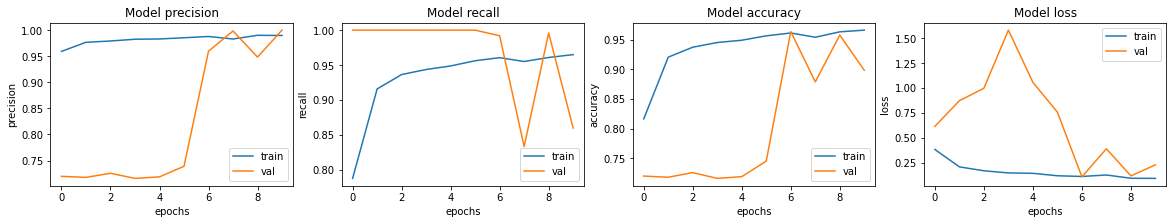

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_1.history[met])
    ax[i].plot(history_1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Batch 사이즈와 Epoch만 바꿨는데도 81.73%의 괜찮은 정확도를 보여준다.

In [23]:
loss, accuracy, precision, recall = model_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 17s 839ms/step - loss: 0.4716 - accuracy: 0.8173 - precision: 0.7961 - recall: 0.9513
Loss: 0.4716097116470337,
Accuracy: 0.817307710647583,
Precision: 0.7961373329162598,
Recall: 0.9512820243835449


***

# - 성능 향상 시도 -

# 이미지를 모노톤으로 처리
# 고대비로 augmentation을 진행해보기도했으나 성능이 더 떨어지는 결과를 보여주었다.
# 이미지 사이즈를 조금 더 늘려보았다.

In [388]:
IMAGE_SIZE = [192, 192]

def decode_img_bw(img):
    img = tf.image.decode_jpeg(img, channels=1) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path_bw(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img_bw(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [389]:
train_ds_bw = train_list_ds.map(process_path_bw, num_parallel_calls=AUTOTUNE)
val_ds_bw = val_list_ds.map(process_path_bw, num_parallel_calls=AUTOTUNE)

In [390]:
for image, label in train_ds_bw.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (192, 192, 1)
Label:  False


In [391]:
BATCH_SIZE = 32

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds_bw = test_list_ds.map(process_path_bw, num_parallel_calls=AUTOTUNE)
test_ds_bw = test_ds_bw.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [392]:
train_ds_bw = prepare_for_training(train_ds_bw)
val_ds_bw = prepare_for_training(val_ds_bw)

***

# 모든 과정에서 노말라이제이션 삭제
# Flatten 이후 Dense 레이어에서 드롭아웃 삭제

In [393]:
def conv_block_2(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 1, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 1, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
    ])
    
    return block

In [394]:
def dense_block_2(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [395]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        
        tf.keras.layers.Conv2D(16, 1, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 1, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 가중치를 통한 데이터 불균형 해결

In [396]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [397]:
with tf.device('/GPU:0'):
    model_2 = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [398]:
model_2.summary()

Model: "sequential_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_298 (Conv2D)          (None, 192, 192, 16)      32        
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 192, 192, 16)      272       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 96, 96, 16)        0         
_________________________________________________________________
sequential_270 (Sequential)  (None, 48, 48, 32)        2160      
_________________________________________________________________
sequential_271 (Sequential)  (None, 24, 24, 64)        7392      
_________________________________________________________________
sequential_272 (Sequential)  (None, 12, 12, 128)       27072     
_________________________________________________________________
dropout_89 (Dropout)         (None, 12, 12, 128)    

In [399]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [400]:
EPOCHS = 10

with tf.device('/GPU:0'):
    history_2 = model_2.fit(
        train_ds_bw,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_bw,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/10
130/130 [==============================] - 39s 252ms/step - loss: 0.4761 - accuracy: 0.6922 - precision: 0.8839 - recall: 0.6665 - val_loss: 0.5980 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 32s 244ms/step - loss: 0.1865 - accuracy: 0.9197 - precision: 0.9851 - recall: 0.9050 - val_loss: 0.5929 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 32s 244ms/step - loss: 0.1184 - accuracy: 0.9481 - precision: 0.9904 - recall: 0.9399 - val_loss: 0.6790 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 32s 245ms/step - loss: 0.1045 - accuracy: 0.9567 - precision: 0.9909 - recall: 0.9504 - val_loss: 1.2560 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 32s 245ms/step - loss: 0.0826 - accura

# 모델링 결과

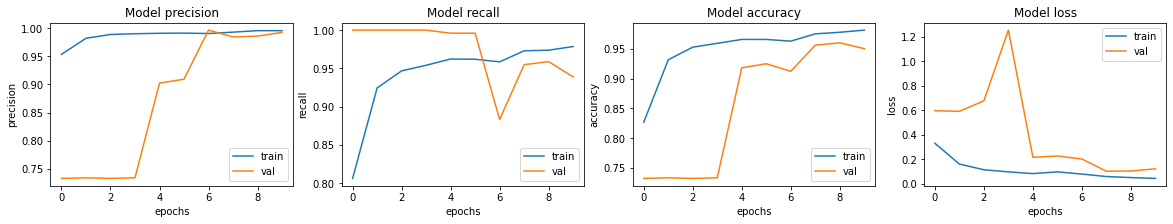

In [401]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_2.history[met])
    ax[i].plot(history_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 정확도 84.61%로 어느정도 유의미한 성능향상 성취
### 이미지 모노톤 변환
### 노말라이제이션 삭제
### Dense 레이어 Dropout 삭제
### Batch 사이즈 수정
### Epoch 수정

In [402]:
loss, accuracy, precision, recall = model_2.evaluate(test_ds_bw)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 30s 2s/step - loss: 0.7089 - accuracy: 0.8462 - precision: 0.8155 - recall: 0.9744
Loss: 0.7088848352432251,
Accuracy: 0.8461538553237915,
Precision: 0.8154506683349609,
Recall: 0.9743589758872986


***

# - 다양한 시도들과 고찰 -

# 의료 데이터의 특징  
  
의료 데이터의 경우 데이터 특성 상 많은 수의 데이터를 많이 확보할 수 없습니다.  
따라서 의료 데이터 관련 인공지능 연구는 적은 데이터 안에서 성능을 끌어올리기 위한 방향으로 진행됩니다.  
이러한 사실을 먼저 인지한 상태에서 성능 개선을 위한 다양한 시도를 진행했습니다.

# 예제 모델 분석  
노드에 제시된 예제 모델은 일반적으로 접해 보지 않은 형태의 CNN 모델이었습니다.  
예제 모델에서는 CNN 레이어의 커널을 모두 1로 두고 깊은 데이터를 깊게 읽어 나가면서 MaxPooling으로 데이터 축소를 진행하고, 마지막에 Flatten 이후 Dense 레이어를 3중으로 활용하고 있습니다.

# 접근법
우선 저는 예제 모델의 CNN과 다르게 커널을 활용하여 순차적으로 데이터를 줄여나가는 기존의 익숙한 방식의 CNN을 적용해 보기로 했습니다.  
MaxPooling 또한 근래에는 Strides를 활용한 유사 Pooling을 더 많이 사용한다고 하는 만큼 Strides를 활용한 유사 Pooling을 구현했습니다.
또한 Dense 레이어의 경우 데이터가 적은 상태에서 3중 레이어가 과적합을 발생시킬 것으로 생각하여 하나의 Dense 레이어를 활용해 보기로 했습니다.  
노말라이제이션의 경우 이미지는 0에서 255 사이의 데이터로 이루어지는 만큼 CNN에서 노말라이제이션은 큰 효과가 없다고 알려져 있어 계산량을 조금이라도 줄여보고자 삭제하기로 했습니다.  
또한 현재 폐렴 이미지는 거의 흑백에 가까운 엑스레이 이미지인 만큼 이미지 모노톤 변환과 고대비 적용 등을 시도했습니다.  
데이터 불균형 해소를 위해서 SMOTE 기법도 고려했습니다.

# 다양한 시도의 결과
위에 언급한 다양한 접근법을 시도했지만 성능 향상을 얻지 못 했습니다. 
오히려 대부분의 시도는 성능 하락으로 이어졌습니다.  
노말라이제이션 삭제와 이미지 모노톤 변화는 최소한 성능을 떨어뜨리지는 않는 것으로 판단되어 계속 사용하기로 했습니다.  
기존의 커널 사이즈를 키운 CNN의 활용은 성능 하락을 보여줬으며, Dense 레이어를 하나만 쓴 경우에 대해서는 학습이 제대로 이루어 지지 않았습니다.  
SMOTE의 경우 결국 기존의 데이터 안에서 비슷한 데이터를 생성하는 만큼 들이는 수고에 비해 예제에서 활용한 가중치 부여 방식보다 더 나은 성능을 내지 못 하는 것으로 결론지어져 사용하지 않게 되었습니다.

# 튜닝의 끝은 순정
결국 예제 모델의 성능을 인정하고 약간의 변형을 가해보기로 했습니다.  
적어도 성능을 떨어뜨리지 않았던 노말라이제이션 삭제와 이미지 모노톤 변환을 유지하고 Dense 레이어에서 드롭아웃을 삭제했습니다.  
여기에 더해 약간의 하이퍼파라미터 튜닝을 진행했고, 최종적으로 84.61이라는 노드 목표치에 근접한 성능을 얻을 수 있었습니다.

# 예제 모델의 강점 분석
결국 이번 노드는 예제 모델이 왜 폐렴 판별 문제에서 강력한 성능을 보여주는지 분석하는 것으로 귀결됩니다.  
### 1사이즈 커널과 깊은 필터를 활용한 CNN과 MaxPooling을 통한 데이터 사이즈 축소
예제 모델의 핵심적인 아이디어라고 생각됩니다.  
고민을 해본 결과 이는 폐렴 엑스레이 데이터의 특징과 연결되는 듯 합니다.  
폐렴 엑스레이 데이터의 경우 폐렴 분포의 모양 보다는 결국 명암의 차이가 판단의 기준이 됩니다.  
따라서 모양보다는 명암을 잘 판단할 수 있도록 깊은 필터로 이미지를 읽어내는 것이 유효한 전략이지 않았나 싶습니다.  
향후에도 이미지의 명암을 판단해야하는 문제에 대해서는 예제 모델과 비슷한 방식을 활용해 볼 수 있을 듯 합니다.  
이 결과에서 왜 이미지 고대비 augmentation이 성능 하락을 불러 일으켰는지 유추해 볼 수 있었습니다.  
이미지를 고대비로 보정할 경우 폐렴 영역의 그라데이션이 무너져 내릴 수 있습니다.  
그렇게 된다면 폐렴 영역에 대한 학습이 제대로 이루어지지 않을 가능성이 있다고 판단됩니다.  
### 3중 Dense 레이어
처음에 3중 Dense 레이어에 대해서 저는 데이터가 적은 만큼 과적합을 방지하는 것이 우선이라고 판단하여 하나의 Dense 레이어를 활용했습니다.  
하지만 데이터의 숫자가 너무 적은 나머지 하나의 Dense 레이어로는 학습이 제대로 이루어지지 못 했습니다.  
결국 과적합도 학습이 된 상태에서 나타나는 만큼 데이터가 적은 경우 학습이 우선시 될 수 밖에 없었고 예제 또한 같은 이유에서 3중 Dense 레이어를 활용한 것으로 생각됩니다.  
예제의 경우 여기서 과적합을 방지하고자 Dropout을 활용한 것으로 생각됩니다.  
적은 데이터에 대해서는 우선적으로 학습을 성공시키고 과적합 문제를 순차적으로 해결하는 것이 정석적인 접근법이라고 느껴졌습니다.